In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# Set display options and plotting style
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

Load the dataset

In [ ]:
# Cell 2: Load the dataset
df = pd.read_csv('career_recommendation_dataset.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset shape: (1000, 15)

First 5 rows:


,Gender,Math_Grade,English_Grade,Kiswahili_Grade,Subject_4,Subject_5,Subject_6,Subject_7,Grade_4,Grade_5,Grade_6,Grade_7,Took_All_Sciences,Average_Performance,Career_Path
0,Male,A,B,B,Chemistry,Agriculture,History,Geography,A,A,A,C,False,3.43,Business Administration
1,Female,B,C,B,Religion,Agriculture,Chemistry,Computer Science,B,E,C,C,False,2.21,Telecommunications
2,Male,C,D,B,Chemistry,Business,Geography,History,F,B,F,D,False,1.43,Education
3,Male,A,B,C,History,Business,Chemistry,Agriculture,D,C,D,B,False,2.29,Music
4,Male,A,C,D,Chemistry,Geography,Agriculture,Business,C,A,A,B,False,2.86,Cybersecurity


Examine the data types and check for missing values

In [ ]:
# Cell 3: Check data types and missing values
print("Data types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

# Check unique values in categorical columns
print("\nUnique subjects:")
for i in range(4, 8):
    col_name = f"Subject_{i}"
    print(f"{col_name}: {df[col_name].unique()}")

print("\nUnique career paths:")
print(df['Career_Path'].value_counts())

Data types:
Gender                  object
Math_Grade              object
English_Grade           object
Kiswahili_Grade         object
Subject_4               object
Subject_5               object
Subject_6               object
Subject_7               object
Grade_4                 object
Grade_5                 object
Grade_6                 object
Grade_7                 object
Took_All_Sciences         bool
Average_Performance    float64
Career_Path             object
dtype: object

Missing values:
Gender                 0
Math_Grade             0
English_Grade          0
Kiswahili_Grade        0
Subject_4              0
Subject_5              0
Subject_6              0
Subject_7              0
Grade_4                0
Grade_5                0
Grade_6                0
Grade_7                0
Took_All_Sciences      0
Average_Performance    0
Career_Path            0
dtype: int64

Unique subjects:
Subject_4: ['Chemistry' 'Religion' 'History' 'Computer Science' 'Agriculture'
 'Busine

Visualize Some aspects of our data

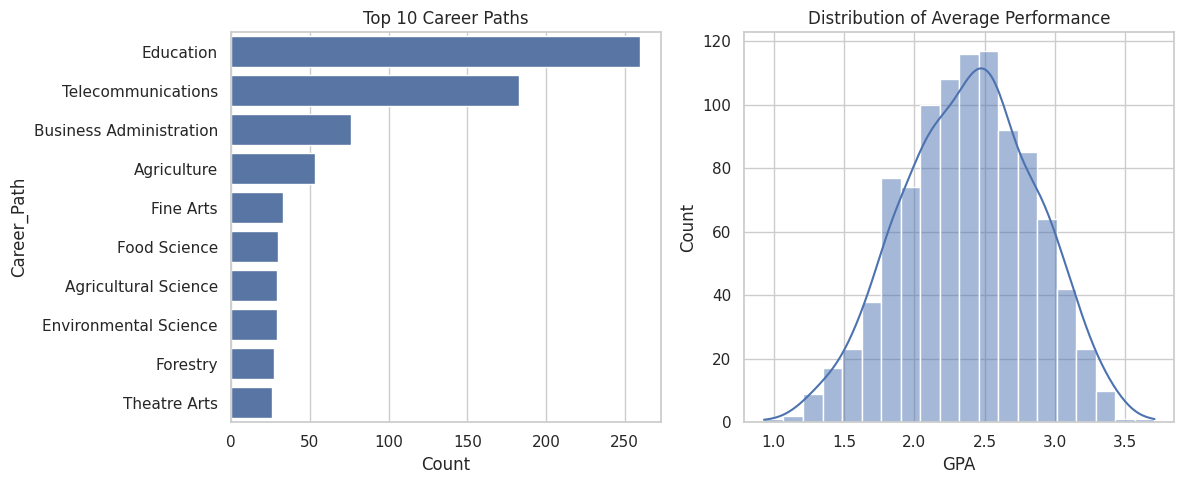

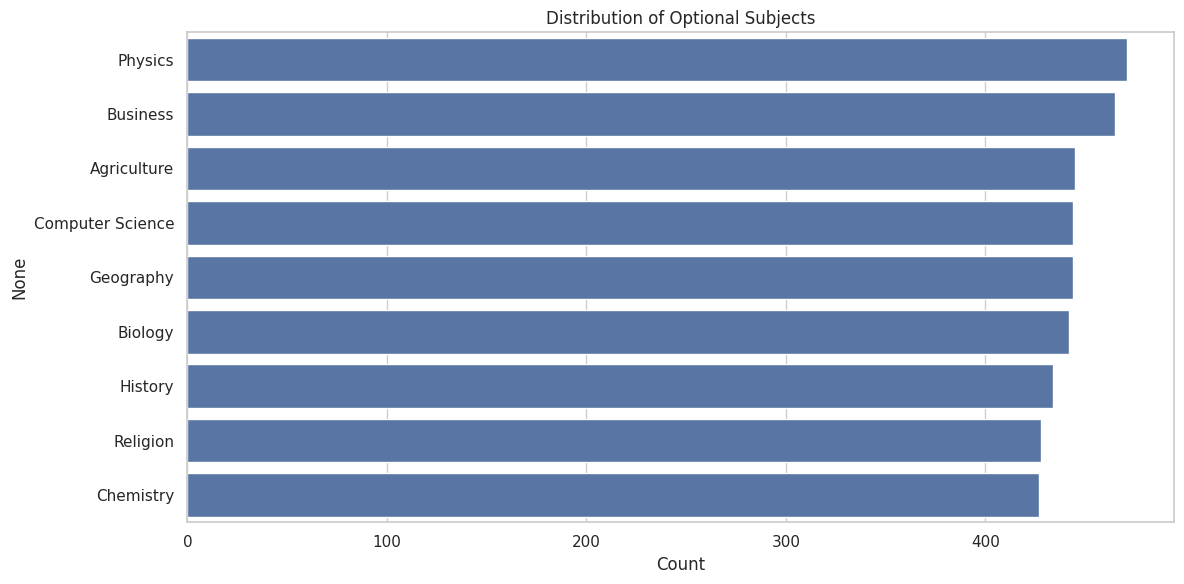

In [ ]:
# Cell 4: Exploratory data visualization
plt.figure(figsize=(12, 5))

# Plot 1: Distribution of career paths
plt.subplot(1, 2, 1)
career_counts = df['Career_Path'].value_counts().sort_values(ascending=False).head(10)
sns.barplot(x=career_counts.values, y=career_counts.index)
plt.title('Top 10 Career Paths')
plt.xlabel('Count')

# Plot 2: Distribution of average performance
plt.subplot(1, 2, 2)
sns.histplot(df['Average_Performance'], bins=20, kde=True)
plt.title('Distribution of Average Performance')
plt.xlabel('GPA')

plt.tight_layout()
plt.show()

# Additional plot: Subject distribution
plt.figure(figsize=(12, 6))
subjects = []
for i in range(4, 8):
    subjects.extend(df[f'Subject_{i}'].tolist())

subject_counts = pd.Series(subjects).value_counts()
sns.barplot(x=subject_counts.values, y=subject_counts.index)
plt.title('Distribution of Optional Subjects')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

Filter out rare career before modeling and prepare data for modelling

In [ ]:
# Cell 5 (Fixed - Option 2): Feature engineering and preprocessing
# Separate features and target
X = df.drop('Career_Path', axis=1)
y = df['Career_Path']

# Find careers with too few examples (less than 2)
career_counts = y.value_counts()
rare_careers = career_counts[career_counts < 2].index.tolist()

if rare_careers:
    print(f"Removing {len(rare_careers)} rare careers: {rare_careers}")
    # Filter out these rare careers
    mask = ~y.isin(rare_careers)
    X = X[mask]
    y = y[mask]
    print(f"Remaining dataset size: {len(y)}")

# Convert grade columns to numeric values
grade_mapping = {'A': 4.0, 'B': 3.0, 'C': 2.0, 'D': 1.0, 'E': 0.5, 'F': 0.0}
for col in ['Math_Grade', 'English_Grade', 'Kiswahili_Grade', 'Grade_4', 'Grade_5', 'Grade_6', 'Grade_7']:
    X[col] = X[col].map(grade_mapping)

# Define categorical and numerical columns
categorical_cols = ['Gender', 'Subject_4', 'Subject_5', 'Subject_6', 'Subject_7']
numerical_cols = ['Math_Grade', 'English_Grade', 'Kiswahili_Grade', 'Grade_4',
                 'Grade_5', 'Grade_6', 'Grade_7', 'Average_Performance']
boolean_cols = ['Took_All_Sciences']

# Split into training and testing sets with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Removing 1 rare careers: ['Civil Engineering']
Remaining dataset size: 999
Training set size: 749
Testing set size: 250


Set up the preprocessing pipeline and train the model


In [ ]:
# Cell 6: Create preprocessing pipeline
# Preprocessor for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', 'passthrough', numerical_cols),
        ('bool', 'passthrough', boolean_cols)
    ])

# Create the full pipeline with the RandomForest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model accuracy: 0.2520

Classification Report:
                           precision    recall  f1-score   support

    AI & Machine Learning       0.00      0.00      0.00         1
               Accounting       0.20      0.25      0.22         4
     Agricultural Science       0.00      0.00      0.00         7
              Agriculture       0.50      0.15      0.24        13
             Architecture       0.00      0.00      0.00         2
  Business Administration       0.22      0.11      0.14        19
         Computer Science       0.00      0.00      0.00         1
               Counseling       0.00      0.00      0.00         3
            Culinary Arts       0.00      0.00      0.00         4
            Cybersecurity       0.00      0.00      0.00         1
             Data Science       0.00      0.00      0.00         1
                Economics       0.00      0.00      0.00         3
                Education       0.30      0.69      0.42        65
    Environmen

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Function to make predictions with our model

In [ ]:
# Cell 7: Create a prediction function for new students
def predict_career(student_data, model):
    """
    Predict career path for a new student

    Parameters:
    student_data (dict): Dictionary containing student information
    model: Trained pipeline model

    Returns:
    str: Predicted career path
    list: Top 3 career recommendations with probabilities
    """
    # Convert to DataFrame
    student_df = pd.DataFrame([student_data])

    # Convert grades to numeric
    grade_cols = ['Math_Grade', 'English_Grade', 'Kiswahili_Grade', 'Grade_4', 'Grade_5', 'Grade_6', 'Grade_7']
    for col in grade_cols:
        if col in student_df.columns:
            student_df[col] = student_df[col].map(grade_mapping)

    # Get prediction
    prediction = model.predict(student_df)[0]

    # Get prediction probabilities
    proba = model.predict_proba(student_df)[0]
    classes = model.classes_
    top_3_idx = proba.argsort()[-3:][::-1]
    top_3_careers = [(classes[i], round(proba[i] * 100, 2)) for i in top_3_idx]

    return prediction, top_3_careers

# Save the model
joblib.dump(pipeline, 'career_recommendation_model.pkl')
print("Model saved as 'career_recommendation_model.pkl'")

Model saved as 'career_recommendation_model.pkl'


Testing our model

In [ ]:
# Cell 8: Test the model with a sample student
sample_student = {
    'Gender': 'Female',
    'Math_Grade': 'A',
    'English_Grade': 'B',
    'Kiswahili_Grade': 'B',
    'Subject_4': 'Biology',
    'Subject_5': 'Chemistry',
    'Subject_6': 'Physics',
    'Subject_7': 'Computer Science',
    'Grade_4': 'A',
    'Grade_5': 'A',
    'Grade_6': 'B',
    'Grade_7': 'A',
    'Took_All_Sciences': True,
    'Average_Performance': 3.57
}

prediction, top_3_careers = predict_career(sample_student, pipeline)

print(f"Predicted career path: {prediction}")
print("\nTop 3 career recommendations:")
for career, probability in top_3_careers:
    print(f"  {career}: {probability}%")

Predicted career path: Accounting

Top 3 career recommendations:
  Accounting: 15.0%
  Environmental Science: 15.0%
  Food Science: 10.0%


A function to take user input for new student and make predictions

In [ ]:
# Cell 9: Create a function to get user input and make predictions
def get_student_input():
    """Get student information from user input"""
    print("Enter student information:")

    gender = input("Gender (Male/Female): ")

    math_grade = input("Math Grade (A/B/C/D/E/F): ")
    english_grade = input("English Grade (A/B/C/D/E/F): ")
    kiswahili_grade = input("Kiswahili Grade (A/B/C/D/E/F): ")

    print("\nSelect 4 optional subjects from:")
    optional_subjects = ["Biology", "Chemistry", "Physics", "Geography", "History",
                         "Religion", "Business", "Computer Science", "Agriculture"]
    for i, subject in enumerate(optional_subjects, 1):
        print(f"{i}. {subject}")

    subject_indices = input("Enter 4 numbers separated by spaces (e.g., 1 2 3 4): ")
    selected_indices = [int(idx) - 1 for idx in subject_indices.split()]

    optional_subjects_selected = [optional_subjects[idx] for idx in selected_indices[:4]]

    grades = []
    for subject in optional_subjects_selected:
        grade = input(f"Grade for {subject} (A/B/C/D/E/F): ")
        grades.append(grade)

    # Check if all sciences are taken
    took_all_sciences = all(subj in optional_subjects_selected for subj in ["Biology", "Chemistry", "Physics"])

    # Calculate GPA
    grade_points = {"A": 4.0, "B": 3.0, "C": 2.0, "D": 1.0, "E": 0.5, "F": 0.0}
    all_grades = [math_grade, english_grade, kiswahili_grade] + grades
    gpa = round(sum([grade_points[g] for g in all_grades]) / 7, 2)

    student_data = {
        "Gender": gender,
        "Math_Grade": math_grade,
        "English_Grade": english_grade,
        "Kiswahili_Grade": kiswahili_grade,
        "Subject_4": optional_subjects_selected[0],
        "Subject_5": optional_subjects_selected[1],
        "Subject_6": optional_subjects_selected[2],
        "Subject_7": optional_subjects_selected[3],
        "Grade_4": grades[0],
        "Grade_5": grades[1],
        "Grade_6": grades[2],
        "Grade_7": grades[3],
        "Took_All_Sciences": took_all_sciences,
        "Average_Performance": gpa
    }

    return student_data

# Load the model (in case we're running this separately)
# model = joblib.load('career_recommendation_model.pkl')

# Uncomment the following lines to run the interactive prediction
student_data = get_student_input()
prediction, top_3_careers = predict_career(student_data, pipeline)
print(f"\nAverage Performance (GPA): {student_data['Average_Performance']}")
print(f"Predicted career path: {prediction}")
print("\nTop 3 career recommendations:")
for career, probability in top_3_careers:
    print(f"  {career}: {probability}%")

Enter student information:
Gender (Male/Female): Male
Math Grade (A/B/C/D/E/F): A
English Grade (A/B/C/D/E/F): C
Kiswahili Grade (A/B/C/D/E/F): B

Select 4 optional subjects from:
1. Biology
2. Chemistry
3. Physics
4. Geography
5. History
6. Religion
7. Business
8. Computer Science
9. Agriculture
Enter 4 numbers separated by spaces (e.g., 1 2 3 4): 2 3 4 9
Grade for Chemistry (A/B/C/D/E/F): C
Grade for Physics (A/B/C/D/E/F): B
Grade for Geography (A/B/C/D/E/F): A
Grade for Agriculture (A/B/C/D/E/F): B

Average Performance (GPA): 3.0
Predicted career path: Telecommunications

Top 3 career recommendations:
  Telecommunications: 22.0%
  Information Technology: 9.0%
  Agricultural Science: 9.0%


Download the model


In [ ]:
# Cell for downloading from Google Colab
from google.colab import files

# Save the model first
joblib.dump(pipeline, 'career_recommendation_model.pkl')

# Download the model file
files.download('career_recommendation_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Sample data
actual = ["Software Engineering", "Data Science", "Graphic Design", "Marketing", "Software Engineering"]
predicted = ["Software Engineering", "Graphic Design", "Data Science", "Marketing", "Data Science"]

# Create confusion matrix
labels = ["Software Engineering", "Data Science", "Graphic Design", "Marketing"]
cm = confusion_matrix(actual, predicted, labels=labels)

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Career Guidance Confusion Matrix")
plt.xlabel("Predicted Career")
plt.ylabel("Actual Career")
plt.show()